# PARAFAC2 Experiment

Can I run PARAFAC on my data. This experiment will merely prove that I can run the tensorly implementation of PARAFAC2 with my dataset. It will require the following: 1. my data is in the right format 2. the tensorly PARAFAC2 code, 3. interpretation of results. What are the results? visualisation of the decomposed modes and a fit, or reconstruction report.

## Preprocessing

Regarding preprocessing, what does PARAFAC2 require? PCA requires normalisation and mean centering, does PARAFAC2? From reading of @bro_parafac2partii_1999 I have to say that it doesn't look like it? Will need further clarification.

## Data Shaping

Will need to fold the data along the sample and wavelength modes/columns. Q: Can I perform parafac on one sample? Will have to test with the dummy dataset. A: Yes. Error does not seem to be significantly affected.

## Scaling and centering

No scaling or centering currently performed. Will review this decision alter.


## Postprocessing

Regarding the results, according to @bro_parafac2partii_1999 [p. 297, sec. "Data", subsec. "Simulated Data", para. 1] the data is organised with analytes as columns, observations as rows, and that we can expect each decomposed mode to have a different shape: in the simulated data, the elution profile has 4 columns (four analytes) with 100 rows (observations), the diagonal matrix D has 4 x 4 rows x columns with the concentration of each analyte in the diagonal, and a spectral profile of 4 columns by 30 rows. So I guess at the very least there should be an equality of rows and columns in the decomposed matrices and the input tensor.

## Tensorly Demonstration Code

The following has been adapted from <https://tensorly.org/stable/auto_examples/decomposition/plot_parafac2.html>.


In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import parafac2
from scipy.optimize import linear_sum_assignment
import duckdb as db
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown


## Data Preparation


In [2]:
def get_data():
    """
    Get the data out of the db.
    """

    db_path = "/Users/jonathan/mres_thesis/wine_analysis_hplc_uv/wines.db"

    with db.connect(db_path) as con:
        data_query = """--sql
            CREATE OR REPLACE TEMP TABLE raw_shiraz AS (
            SELECT
                *
            FROM
                pbl.sample_metadata
            WHERE
                detection='raw'
            AND
              varietal='shiraz'
            ORDER BY
                sample_num
            );
            SELECT
                *
            FROM
                pbl.chromatogram_spectra_long as cs
            JOIN
            raw_shiraz
            USING
                (id)
            WHERE
                cs.mins < 30
            ORDER BY
                sample_num, cs.wavelength, idx
                ;
            """

        get_sm_query = """--sql
        select * from raw_shiraz;
        """

        data = con.sql(data_query).pl()
        sm = con.sql(get_sm_query).pl()

        return data, sm


long_data, sm = get_data()
display(Markdown("## Sample Metadata"), sm)
display(Markdown("## Sample Metadata"), long_data.head(), long_data.tail())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Sample Metadata

detection,acq_date,wine,color,varietal,samplecode,id,sample_num
str,str,str,str,str,str,str,i64
"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""","""a69d4665-d7b3-4706-be76-4d8e39…",6
"""raw""","""2023-02-15 23:25:01""","""2020 torbreck shiraz the strui…","""red""","""shiraz""","""15""","""744f6f00-931b-4e6d-8403-e4d302…",10
"""raw""","""2023-03-15 02:06:21""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""39""","""9a54820f-861a-41fa-8eb4-566abc…",38
"""raw""","""2023-03-21 18:53:41""","""2019 shaw and smith shiraz bal…","""red""","""shiraz""","""61""","""7f2e6628-7323-4c61-853c-2e3bc8…",60
"""raw""","""2023-03-21 19:47:21""","""2020 spinifex shiraz bete noir""","""red""","""shiraz""","""62""","""a6c0cc7f-5c1d-4360-9124-4211f4…",61
…,…,…,…,…,…,…,…
"""raw""","""2023-04-04 18:18:05""","""2020 yangarra estate shiraz mc…","""red""","""shiraz""","""82""","""7563b30e-eca5-487a-be62-31b7b3…",75
"""raw""","""2023-04-05 02:19:33""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""84""","""77a0e17d-08f2-4f44-9ad4-4f6291…",84
"""raw""","""2023-04-21 14:43:48""","""2021 chris ringland shiraz""","""red""","""shiraz""","""a0301""","""7b085f32-4d69-4f78-b49b-4d3287…",91


## Sample Metadata

idx,id,mins,wavelength,absorbance,detection,acq_date,wine,color,varietal,samplecode,sample_num
i64,str,f64,i32,f64,str,str,str,str,str,str,i64
0,"""a69d4665-d7b3-4706-be76-4d8e39…",0.003117,190,1.61662,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
1,"""a69d4665-d7b3-4706-be76-4d8e39…",0.009783,190,1.565613,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
2,"""a69d4665-d7b3-4706-be76-4d8e39…",0.01645,190,1.352809,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
3,"""a69d4665-d7b3-4706-be76-4d8e39…",0.023117,190,0.841774,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
4,"""a69d4665-d7b3-4706-be76-4d8e39…",0.029783,190,-0.113733,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6


idx,id,mins,wavelength,absorbance,detection,acq_date,wine,color,varietal,samplecode,sample_num
i64,str,f64,i32,f64,str,str,str,str,str,str,i64
4495,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.971867,400,0.307456,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4496,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.978533,400,0.305735,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4497,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.9852,400,0.304386,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4498,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.991867,400,0.30347,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4499,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.998533,400,0.302941,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103


In [3]:
# checking for duplicate samples

long_data.filter(pl.col('wavelength').eq(256)).group_by('sample_num').len().sort('sample_num')


sample_num,len
i64,u32
6,4500
10,4500
38,4500
60,4500
61,4500
…,…
75,4500
84,4500
91,4500


In [4]:
long_data.group_by('sample_num').agg(pl.col('wavelength').min().alias('wavelength_min'), pl.col('wavelength').max().alias('wavelength_max')).describe()


statistic,sample_num,wavelength_min,wavelength_max
str,f64,f64,f64
"""count""",11.0,11.0,11.0
"""null_count""",0.0,0.0,0.0
"""mean""",63.090909,190.0,400.0
"""std""",33.131419,0.0,0.0
"""min""",6.0,190.0,400.0
"""25%""",60.0,190.0,400.0
"""50%""",67.0,190.0,400.0
"""75%""",91.0,190.0,400.0
"""max""",103.0,190.0,400.0


time ranges..

In [5]:
long_data.group_by('sample_num').agg(pl.col('mins').min().alias('min'), pl.col('mins').max().alias('max')).describe()


statistic,sample_num,min,max
str,f64,f64,f64
"""count""",11.0,11.0,11.0
"""null_count""",0.0,0.0,0.0
"""mean""",63.090909,0.003973,29.997306
"""std""",33.131419,0.001826,0.001826
"""min""",6.0,0.00125,29.994583
"""25%""",60.0,0.003117,29.99645
"""50%""",67.0,0.004367,29.9977
"""75%""",91.0,0.0052,29.998533
"""max""",103.0,0.00645,29.999783


Varies a bit.. cut it off at 25 mins.

### Fold to Tensor

Need to fold the data across the sample and wavelength modes to form a 3 mode tensor. See <https://tensorly.org/stable/user_guide/tensor_basics.html#folding>

In [6]:
long_df = long_data.filter(pl.col('mins').le(25)).select("sample_num","mins", "absorbance", "wavelength")
long_df


sample_num,mins,absorbance,wavelength
i64,f64,f64,i32
6,0.003117,1.61662,190
6,0.009783,1.565613,190
6,0.01645,1.352809,190
6,0.023117,0.841774,190
6,0.029783,-0.113733,190
…,…,…,…
103,24.971867,0.582419,400
103,24.978533,0.579372,400
103,24.9852,0.57622,400


In [7]:
# rank sample_num to have as continuous numerical

long_df = long_df.with_columns(pl.col("sample_num").rank('dense').alias('sample_num_rank'))
long_df


sample_num,mins,absorbance,wavelength,sample_num_rank
i64,f64,f64,i32,u32
6,0.003117,1.61662,190,1
6,0.009783,1.565613,190,1
6,0.01645,1.352809,190,1
6,0.023117,0.841774,190,1
6,0.029783,-0.113733,190,1
…,…,…,…,…
103,24.971867,0.582419,400,11
103,24.978533,0.579372,400,11
103,24.9852,0.57622,400,11


In [8]:
long_df.select('sample_num_rank').n_unique()


11

Are all wavelength ranges the same?

In [12]:
long_df.select('wavelength')


wavelength
i32
190
190
190
190
190
…
400
400
400


In [13]:
dfs = [df for df in long_df.select('sample_num_rank','mins','absorbance','wavelength').pivot(on='wavelength', index=['sample_num_rank','mins'], values='absorbance').partition_by('sample_num_rank')]

print([df.shape for df in dfs])
I = 1
J = 3750
K = long_df.select('wavelength').n_unique()+2

df_1_reshaped = dfs[1].to_numpy().reshape(1, J, K)

print("reshaped frame shape:", df_1_reshaped.shape)


[(3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108)]
reshaped frame shape: (1, 3750, 108)


sample_num_rank,mins,190,192,194,196,198,200,202,204,206,208,210,212,214,216,218,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,…,328,330,332,334,336,338,340,342,344,346,348,350,352,354,356,358,360,362,364,366,368,370,372,374,376,378,380,382,384,386,388,390,392,394,396,398,400
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,0.003117,1.61662,1.053303,0.609621,0.301898,0.122406,0.018336,-0.051998,-0.089899,-0.101574,-0.088684,-0.070132,-0.060081,-0.051625,-0.039741,-0.032112,-0.026017,-0.0147,-0.001431,0.009894,0.016525,0.020467,0.021294,0.019453,0.02034,0.018746,0.013627,0.009499,0.004292,0.000045,-0.001013,-0.001751,-0.003256,-0.00336,-0.001594,-0.002109,…,-0.009425,-0.005111,-0.006095,-0.001885,0.004582,0.000507,-0.002079,-0.001684,-0.001863,-0.000626,-0.001244,-0.000201,0.002876,0.003323,-0.001691,-0.008136,-0.008516,-0.007443,-0.006281,-0.004366,-0.004321,-0.004917,-0.005424,-0.002056,0.007018,0.012301,0.006601,-0.004537,-0.009231,-0.005916,-0.008114,-0.00529,0.00117,0.000201,0.000179,0.001207,0.00044
1,0.009783,1.565613,1.016937,0.587061,0.288956,0.115298,0.014521,-0.054926,-0.092275,-0.10334,-0.090092,-0.070959,-0.06035,-0.052191,-0.040799,-0.033483,-0.027508,-0.016175,-0.003166,0.008091,0.015028,0.018977,0.019751,0.018395,0.019528,0.017874,0.012442,0.008076,0.002727,-0.001796,-0.003144,-0.00371,-0.004157,-0.004165,-0.002906,-0.003234,…,-0.011146,-0.007309,-0.007913,-0.003822,0.002287,-0.001095,-0.003234,-0.002824,-0.002667,-0.003211,-0.004038,-0.001155,0.001505,0.001237,-0.003986,-0.010401,-0.010498,-0.009812,-0.009008,-0.006013,-0.005387,-0.006974,-0.007659,-0.004359,0.004098,0.009336,0.004023,-0.006229,-0.011012,-0.008479,-0.010051,-0.006296,-0.00041,-0.002362,-0.002921,-0.001654,-0.001758
1,0.01645,1.352809,0.874534,0.501662,0.242636,0.09083,0.001021,-0.063375,-0.097938,-0.107415,-0.093527,-0.073776,-0.062078,-0.053927,-0.042774,-0.035889,-0.030294,-0.019059,-0.006303,0.004947,0.012085,0.01587,0.016704,0.016063,0.017226,0.015363,0.009798,0.005007,-0.000514,-0.005081,-0.00678,-0.007316,-0.006698,-0.006557,-0.005707,-0.005871,…,-0.013955,-0.01061,-0.010759,-0.006795,-0.001349,-0.003748,-0.005499,-0.005431,-0.005178,-0.007063,-0.007674,-0.003487,-0.001185,-0.002421,-0.008292,-0.013776,-0.013262,-0.013173,-0.012971,-0.008836,-0.007533,-0.009976,-0.010997,-0.008047,-0.0007,0.004247,-0.000313,-0.00938,-0.013627,-0.011832,-0.012919,-0.00868,-0.003614,-0.006184,-0.007123,-0.005797,-0.005253
1,0.023117,0.841774,0.536509,0.300728,0.135034,0.034995,-0.029422,-0.081398,-0.109591,-0.116192,-0.100799,-0.080027,-0.066742,-0.058241,-0.046894,-0.040285,-0.035331,-0.024468,-0.01166,-0.000201,0.006974,0.010595,0.011466,0.011533,0.012562,0.010327,0.004783,-0.000432,-0.006236,-0.010885,-0.012882,-0.013545,-0.012077,-0.011548,-0.0109,-0.010729,…,-0.018321,-0.015311,-0.015624,-0.011921,-0.006862,-0.008278,-0.009649,-0.009879,-0.009798,-0.012845,-0.012927,-0.007682,-0.005677,-0.008017,-0.014529,-0.018679,-0.017747,-0.018194,-0.018604,-0.013888,-0.011973,-0.014685,-0.016063,-0.013895,-0.008404,-0.004485,-0.0076,-0.014655,-0.018075,-0.017114,-0.017822,-0.012897,-0.008844,-0.011683,-0.012651,-0.011414,-0.010349
1,0.029783,-0.113733,-0.094101,-0.072598,-0.063673,-0.067122,-0.084408,-0.11342,-0.130184,-0.13157,-0.113159,-0.090599,-0.075139,-0.0659,-0.053905,-0.047281,-0.04296,-0.032671,-0.019491,-0.00757,-0.000685,0.002615,0.003651,0.004344,0.005148,0.002481,-0.003204,-0.008896,-0.015035,-0.019699,-0.021622,-0.022419,-0.020593,-0.01961,-0.019021,-0.018485,…,-0.02446,-0.02224,-0.023358,-0.019595,-0.014476,-0.014856,-0.015855,-0.016503,-0.016592,-0.02075,-0.020519,-0.014335,-0.012569,-0.015676,-0.022411,-0.025146,-0.024021,-0.025041,-0.025965,-0.021271,-0.018679,-0.021

In [27]:
# lookup for wavelength to numpy indice mapping

wavelength_ranking = long_df.select(pl.col('wavelength').unique()).with_columns(pl.col('wavelength').rank('dense').sub(1).alias('rank'))
wavelength_ranking.filter(pl.col('wavelength').eq(256))


wavelength,rank
i32,u32
256,33


In [28]:
wavelength_ranking[0]


wavelength,rank
i32,u32
190,0


(11, 3750, 108)


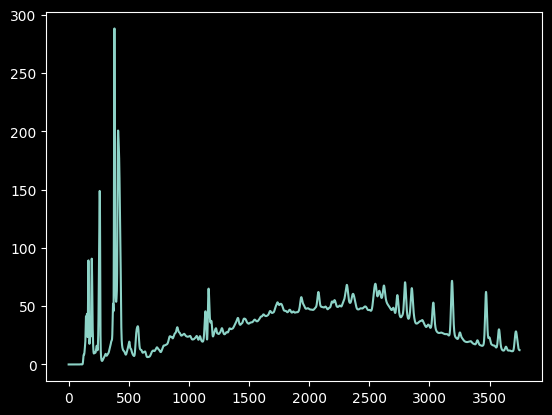

In [35]:
np_arrays = [df.to_numpy() for df in dfs]
tensor = np.stack(np_arrays)
print(tensor.shape)
plt.plot(tensor[1,:,33])


## Running the data

Lets give the data a whirl, now that its tensor-i-fied. I suspect some white wines would be an easier prospect considering the absence of a shifting baseline.

In [39]:
best_err = np.inf
decomposition = None

true_rank = 30

for run in range(1):
    print(f'Training model {run}...')
    trial_decomposition, trial_errs = parafac2(tensor, true_rank, return_errors=True, tol=1e-8, n_iter_max=500, random_state=run, verbose=True)
    print(f'Number of iterations: {len(trial_errs)}')
    print(f'Final error: {trial_errs[-1]}')
    if best_err > trial_errs[-1]:
        best_err = trial_errs[-1]
        err = trial_errs
        decomposition = trial_decomposition
    print('-------------------------------')
print(f'Best model error: {best_err}')


Training model 0...
Starting iteration 0
reconstruction error=0.12796135120924976
iteration 1, reconstruction error: 0.05133595095293837, decrease = 0.07662540025631139, unnormalized = 21519.155511571855
iteration 2, reconstruction error: 0.03560037161850967, decrease = 0.0157355793344287, unnormalized = 14923.068900209186
iteration 3, reconstruction error: 0.031839487501260165, decrease = 0.0037608841172495078, unnormalized = 13346.570390338678
iteration 4, reconstruction error: 0.029296194983687504, decrease = 0.002543292517572661, unnormalized = 12280.46552267516
PARAFAC2 reconstruction error=0.029297042154317283
Starting iteration 1
reconstruction error=0.01375570791424459
iteration 1, reconstruction error: 0.013450007076116311, decrease = 0.00030570083812827935, unnormalized = 5638.013802984094
iteration 2, reconstruction error: 0.013291503434018736, decrease = 0.00015850364209757557, unnormalized = 5571.57177682663
iteration 3, reconstruction error: 0.013179441071691247, decrease

In [43]:
decomposition


(weights, factors, projections) : rank-30 Parafac2Tensor of shape ((3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108), (3750, 108)) 

In [51]:
est_B[0].shape


(3750, 30)

In [101]:
tensor[[1]].shape


(1, 3750, 108)

In [111]:
def fit_parafac_2(tensor, true_rank, **kwargs):

    best_err = np.inf
    decomposition = None

    true_rank = 30

    for run in range(1):
        print(f'Training model {run}...')
        trial_decomposition, trial_errs = parafac2(tensor, true_rank, return_errors=True, tol=1e-8, n_iter_max=500, random_state=run, verbose=True, **kwargs)
        print(f'Number of iterations: {len(trial_errs)}')
        print(f'Final error: {trial_errs[-1]}')
        if best_err > trial_errs[-1]:
            best_err = trial_errs[-1]
            err = trial_errs
            decomposition = trial_decomposition
        print('-------------------------------')
    print(f'Best model error: {best_err}')

    est_tensor = tl.parafac2_tensor.parafac2_to_tensor(decomposition)
    est_weights, (est_A, est_B, est_C) = tl.parafac2_tensor.apply_parafac2_projections(decomposition)

    return decomposition, est_tensor, est_weights, est_A, est_B, est_C

decomposition, est_tensor, est_weights, est_A, est_B, est_C = fit_parafac_2(tensor=tensor[[1]], true_rank=30, nn_modes='all')


Training model 0...
Starting iteration 0
reconstruction error=0.1435700494290087
iteration 1, reconstruction error: 0.03012649789882306, decrease = 0.11344355153018564
iteration 2, reconstruction error: 0.01912110265578535, decrease = 0.01100539524303771
iteration 3, reconstruction error: 0.015577517327621573, decrease = 0.0035435853281637775
iteration 4, reconstruction error: 0.014186790075894644, decrease = 0.0013907272517269288
PARAFAC2 reconstruction error=0.014190172505608214
Starting iteration 1


/Users/jonathan/Library/Caches/pypoetry/virtualenvs/pca-analysis-6KQS4gUX-py3.12/lib/python3.12/site-packages/tensorly/decomposition/_parafac2.py:291: UserWarning: Mode `1` of PARAFAC2 fitted with ALS cannot be constrained to be truly non-negative. See the documentation for more info.
  warn(


reconstruction error=0.007196526137843672
iteration 1, reconstruction error: 0.006586854051927258, decrease = 0.0006096720859164141
iteration 2, reconstruction error: 0.006275428342983366, decrease = 0.00031142570894389203
iteration 3, reconstruction error: 0.006077230577323079, decrease = 0.0001981977656602867
iteration 4, reconstruction error: 0.005942528147947339, decrease = 0.00013470242937574026
PARAFAC2 reconstruction error=0.006086104693799659, variation=0.008104067811808554.
Starting iteration 2
reconstruction error=0.004098383455658978
iteration 1, reconstruction error: 0.003941906628571998, decrease = 0.0001564768270869805
iteration 2, reconstruction error: 0.00384637438463069, decrease = 9.553224394130743e-05
iteration 3, reconstruction error: 0.003773251929693118, decrease = 7.31224549375721e-05
iteration 4, reconstruction error: 0.0037122803148599602, decrease = 6.097161483315785e-05
PARAFAC2 reconstruction error=0.0039050566659614696, variation=0.0021810480278381898.
Star

In [115]:
decomposition.projections


[array([[ 2.71894621e-01, -3.82070907e-01, -1.26672755e-02, ...,
          9.53470348e-03,  3.11389690e-02, -6.38439998e-02],
        [-1.56693357e-02,  1.28567298e-03,  6.86501901e-03, ...,
         -8.53104951e-03,  3.08509986e-02,  1.76441431e-02],
        [ 9.32522857e-03, -1.53873228e-02,  6.47586430e-04, ...,
          4.15803261e-03,  6.53782221e-03, -9.09758511e-03],
        ...,
        [-3.78591070e-03, -2.97182798e-02,  2.86800111e-02, ...,
         -4.67518883e-03,  6.29075585e-05, -6.54918067e-03],
        [ 2.56173431e-02, -1.77556589e-02, -1.50720434e-02, ...,
         -3.96135597e-03, -2.64092098e-03, -2.06845492e-02],
        [ 1.28347834e-02, -2.94140061e-02,  2.17215166e-02, ...,
          4.36972646e-04,  3.97216346e-03, -1.56029926e-02]])]

(3750, 30)
(3750,)


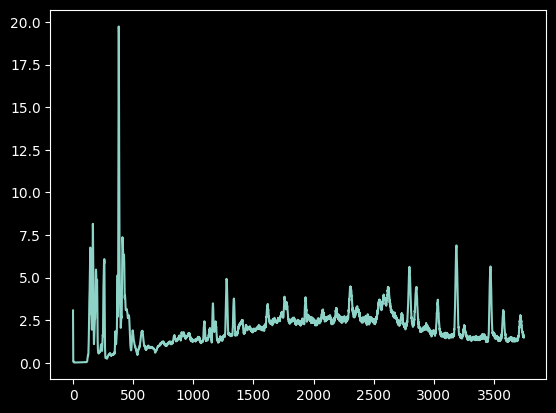

In [113]:
sample = 0

print(est_B[sample].shape)
x = np.sum(np.abs(est_B[sample]), axis=1)
print(x.shape)
plt.plot(x);


In [119]:
tensor_diff = tensor[[1]] - est_tensor
tensor_diff / tensor[[1]]


array([[[ 9.98184236e-01, -5.45346818e+00, -1.82841233e-02, ...,
         -6.14477731e-02, -7.70053102e-01, -1.54412897e+00],
        [ 9.98101067e-01, -7.67684096e-01, -2.03222923e-02, ...,
          3.12529959e-01, -2.58353646e-01, -1.10462260e+00],
        [ 9.98086226e-01,  5.44089649e-02, -9.87655160e-03, ...,
          9.00418076e-02, -8.38498706e-01, -2.43432265e+00],
        ...,
        [ 1.97191573e-01,  4.89029126e-02,  2.75318994e-04, ...,
          2.34908513e-01,  2.24498328e-01,  2.20791899e-01],
        [ 1.97586563e-01,  4.91600896e-02,  2.78323975e-04, ...,
          2.35826925e-01,  2.25369344e-01,  2.22301911e-01],
        [ 1.97717260e-01,  4.94144649e-02,  2.79307948e-04, ...,
          2.37372869e-01,  2.26932101e-01,  2.24496084e-01]]])

(3750,)


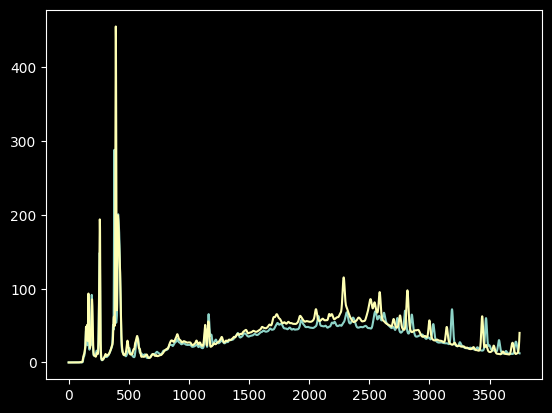

In [126]:
x = est_tensor[0,:,33]
print(x.shape)
plt.plot(x)
plt.plot(tensor[0,:,33xc])

